In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision.models as models
# This is for the progress bar.
from tqdm import tqdm
import seaborn as sns

In [2]:
labels_dataframe = pd.read_csv('F:/code/deeplearningfollowlimu/race2/train.csv')
labels_dataframe.head(5)

,image,label
0,images/0.jpg,maclura_pomifera
1,images/1.jpg,maclura_pomifera
2,images/2.jpg,maclura_pomifera
3,images/3.jpg,maclura_pomifera
4,images/4.jpg,maclura_pomifera


我们也可以在[**增加输出通道数的同时，减半输出的高和宽**]。


In [3]:
labels_dataframe.describe()

,image,label
count,18353,18353
unique,18353,176
top,images/0.jpg,maclura_pomifera
freq,1,353


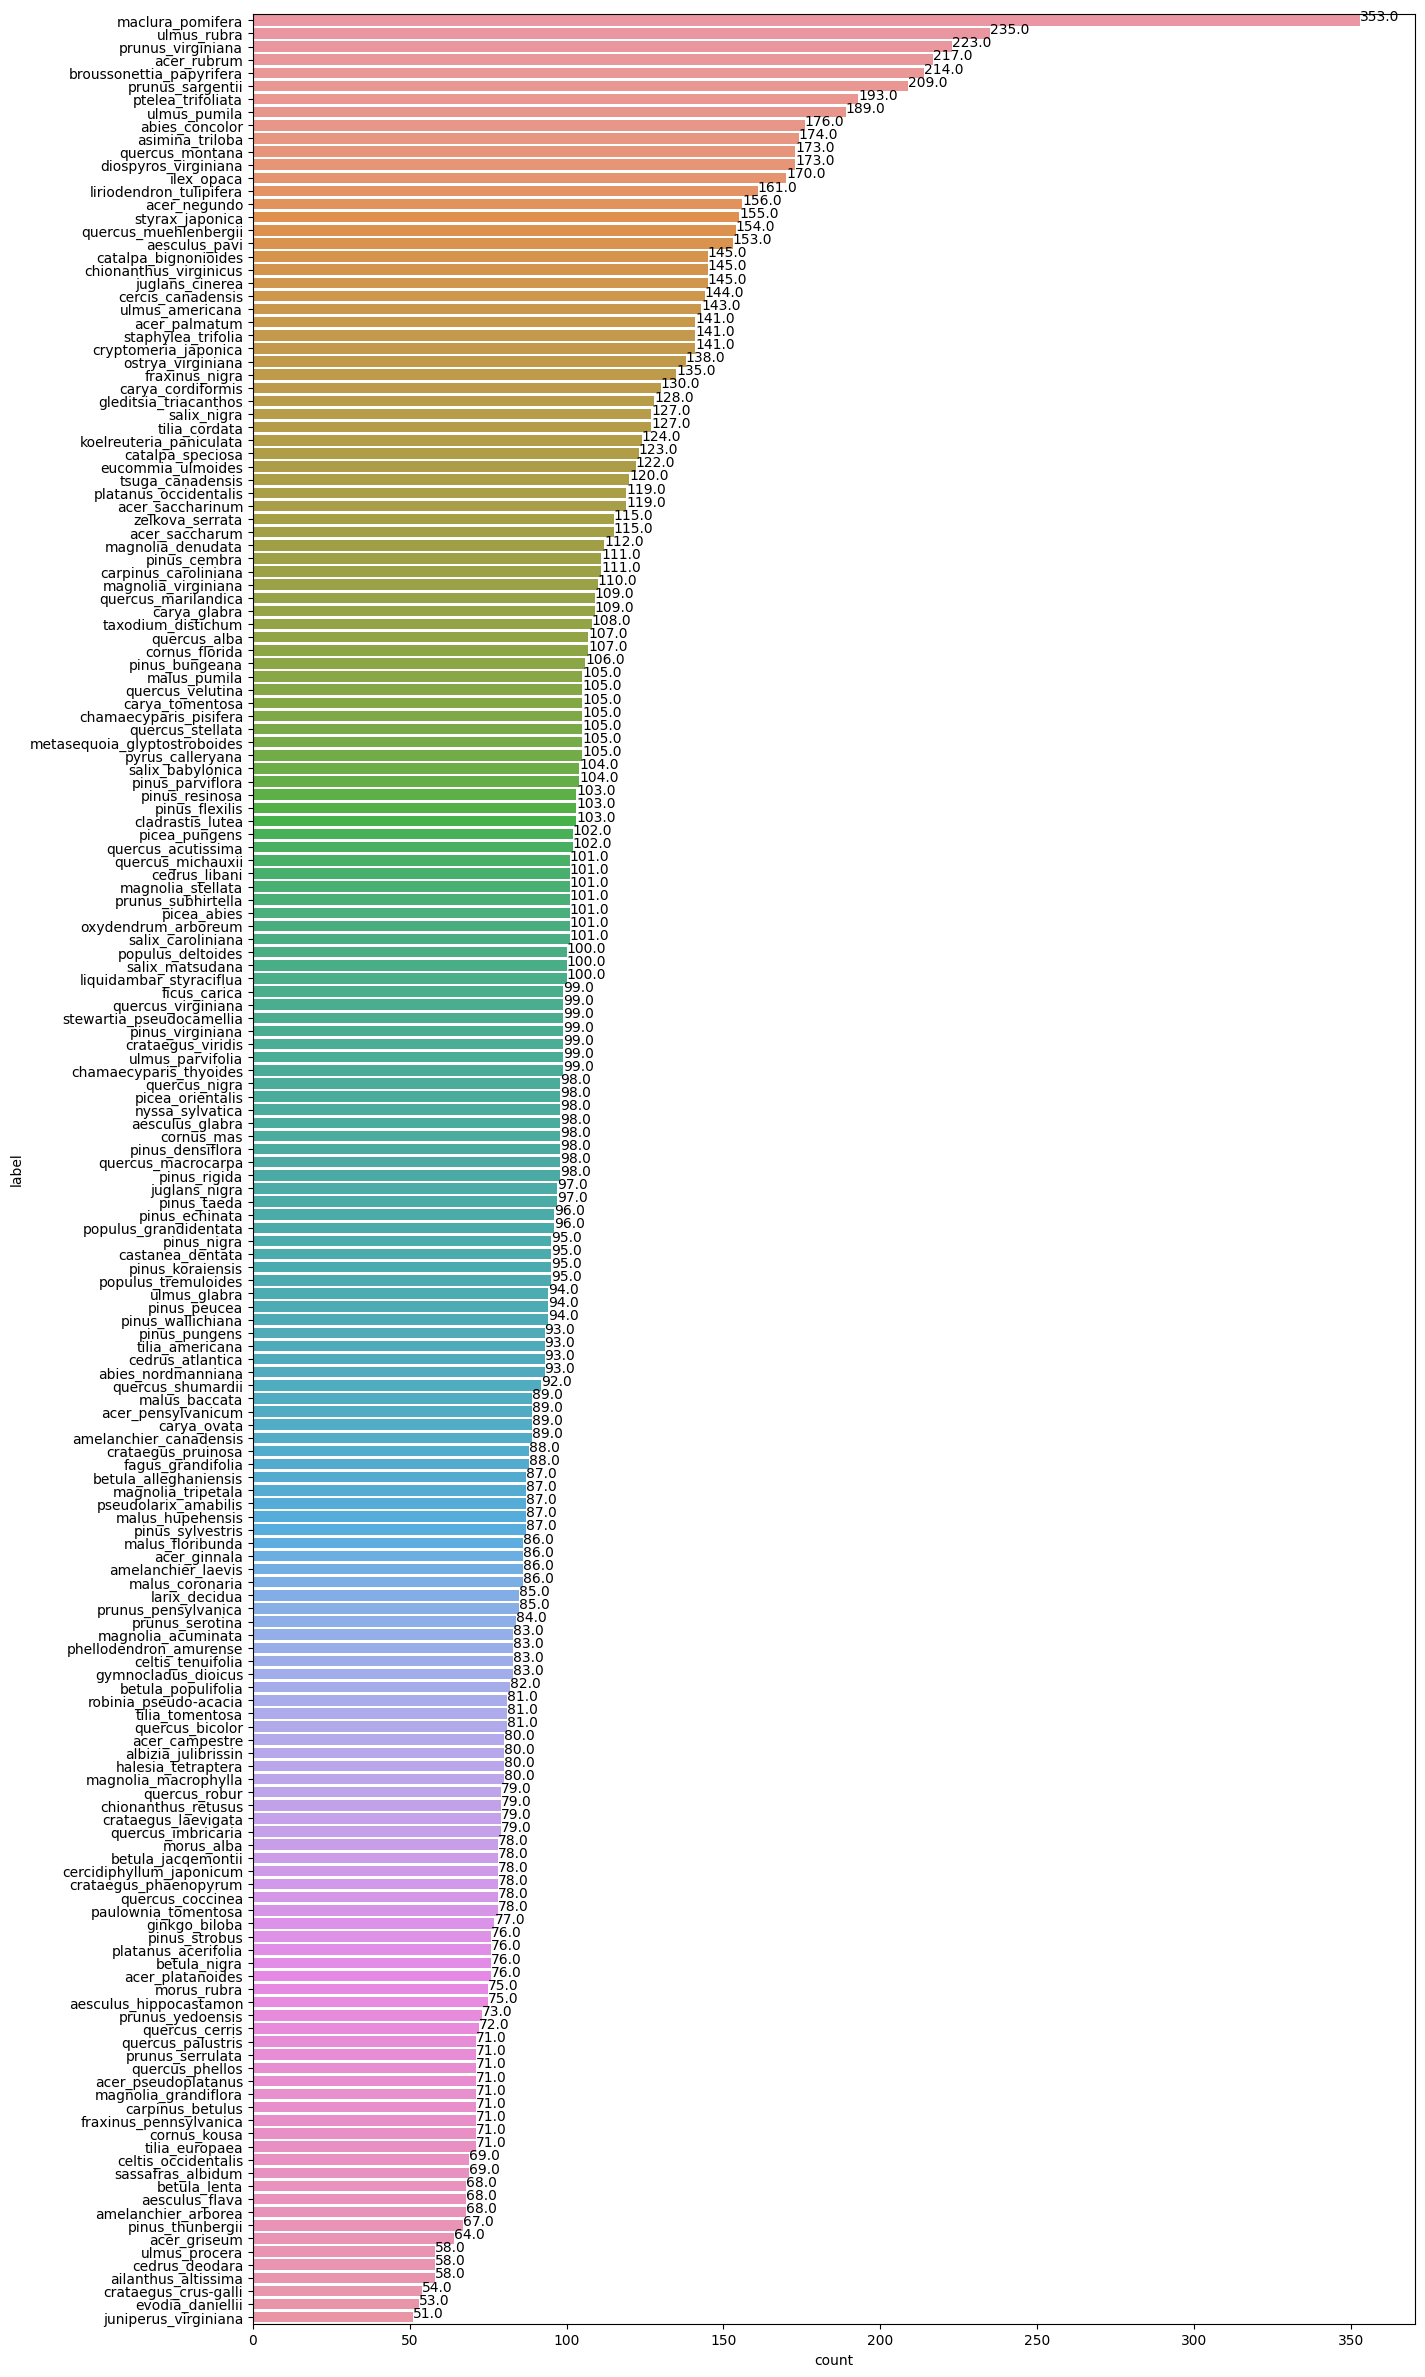

In [4]:
#function to show bar length

def barw(ax): 
    
    for p in ax.patches:
        val = p.get_width() #height of the bar
        x = p.get_x()+ p.get_width() # x- position 
        y = p.get_y() + p.get_height()/2 #y-position
        ax.annotate(round(val,2),(x,y))
        
#finding top leaves

plt.figure(figsize = (15,30))
ax0 =sns.countplot(y=labels_dataframe['label'],order=labels_dataframe['label'].value_counts().index)
barw(ax0)
plt.show()

In [5]:
# 把label文件排个序
leaves_labels = sorted(list(set(labels_dataframe['label'])))
n_classes = len(leaves_labels)
print(n_classes)
leaves_labels[:10]

176


['abies_concolor',
 'abies_nordmanniana',
 'acer_campestre',
 'acer_ginnala',
 'acer_griseum',
 'acer_negundo',
 'acer_palmatum',
 'acer_pensylvanicum',
 'acer_platanoides',
 'acer_pseudoplatanus']

In [6]:
# 把label转成对应的数字
class_to_num = dict(zip(leaves_labels, range(n_classes)))
class_to_num

{'abies_concolor': 0,
 'abies_nordmanniana': 1,
 'acer_campestre': 2,
 'acer_ginnala': 3,
 'acer_griseum': 4,
 'acer_negundo': 5,
 'acer_palmatum': 6,
 'acer_pensylvanicum': 7,
 'acer_platanoides': 8,
 'acer_pseudoplatanus': 9,
 'acer_rubrum': 10,
 'acer_saccharinum': 11,
 'acer_saccharum': 12,
 'aesculus_flava': 13,
 'aesculus_glabra': 14,
 'aesculus_hippocastamon': 15,
 'aesculus_pavi': 16,
 'ailanthus_altissima': 17,
 'albizia_julibrissin': 18,
 'amelanchier_arborea': 19,
 'amelanchier_canadensis': 20,
 'amelanchier_laevis': 21,
 'asimina_triloba': 22,
 'betula_alleghaniensis': 23,
 'betula_jacqemontii': 24,
 'betula_lenta': 25,
 'betula_nigra': 26,
 'betula_populifolia': 27,
 'broussonettia_papyrifera': 28,
 'carpinus_betulus': 29,
 'carpinus_caroliniana': 30,
 'carya_cordiformis': 31,
 'carya_glabra': 32,
 'carya_ovata': 33,
 'carya_tomentosa': 34,
 'castanea_dentata': 35,
 'catalpa_bignonioides': 36,
 'catalpa_speciosa': 37,
 'cedrus_atlantica': 38,
 'cedrus_deodara': 39,
 'cedru

In [7]:
# 再转换回来，方便最后预测的时候使用
num_to_class = {v : k for k, v in class_to_num.items()}

In [8]:
# 继承pytorch的dataset，创建自己的
class LeavesData(Dataset):
    def __init__(self, csv_path, file_path, mode='train', valid_ratio=0.2, resize_height=256, resize_width=256):
        """
        Args:
            csv_path (string): csv 文件路径
            img_path (string): 图像文件所在路径
            mode (string): 训练模式还是测试模式
            valid_ratio (float): 验证集比例
        """
        
        # 需要调整后的照片尺寸，我这里每张图片的大小尺寸不一致#
        self.resize_height = resize_height
        self.resize_width = resize_width

        self.file_path = file_path
        self.mode = mode

        # 读取 csv 文件
        # 利用pandas读取csv文件
        self.data_info = pd.read_csv(csv_path, header=None)  #header=None是去掉表头部分
        # 计算 length
        self.data_len = len(self.data_info.index) - 1
        self.train_len = int(self.data_len * (1 - valid_ratio))
        
        if mode == 'train':
            # 第一列包含图像文件的名称
            self.train_image = np.asarray(self.data_info.iloc[1:self.train_len, 0])  #self.data_info.iloc[1:,0]表示读取第一列，从第二行开始到train_len
            # 第二列是图像的 label
            self.train_label = np.asarray(self.data_info.iloc[1:self.train_len, 1])
            self.image_arr = self.train_image 
            self.label_arr = self.train_label
        elif mode == 'valid':
            self.valid_image = np.asarray(self.data_info.iloc[self.train_len:, 0])  
            self.valid_label = np.asarray(self.data_info.iloc[self.train_len:, 1])
            self.image_arr = self.valid_image
            self.label_arr = self.valid_label
        elif mode == 'test':
            self.test_image = np.asarray(self.data_info.iloc[1:, 0])
            self.image_arr = self.test_image
            
        self.real_len = len(self.image_arr)

        print('Finished reading the {} set of Leaves Dataset ({} samples found)'
              .format(mode, self.real_len))

    def __getitem__(self, index):
        # 从 image_arr中得到索引对应的文件名
        single_image_name = self.image_arr[index]

        # 读取图像文件
        img_as_img = Image.open(self.file_path + single_image_name)

        #如果需要将RGB三通道的图片转换成灰度图片可参考下面两行
#         if img_as_img.mode != 'L':
#             img_as_img = img_as_img.convert('L')

        #设置好需要转换的变量，还可以包括一系列的nomarlize等等操作
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),   #随机水平翻转 选择一个概率
                transforms.ToTensor()
            ])
        else:
            # valid和test不做数据增强
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])
        
        img_as_img = transform(img_as_img)
        
        if self.mode == 'test':
            return img_as_img
        else:
            # 得到图像的 string label
            label = self.label_arr[index]
            # number label
            number_label = class_to_num[label]

            return img_as_img, number_label  #返回每一个index对应的图片数据和对应的label

    def __len__(self):
        return self.real_len

In [9]:
train_path = 'F:/code/deeplearningfollowlimu/race2/train.csv'
test_path = 'F:/code/deeplearningfollowlimu/race2/test.csv'
# csv文件中已经images的路径了，因此这里只到上一级目录
img_path = 'F:/code/deeplearningfollowlimu/race2/'

train_dataset = LeavesData(train_path, img_path, mode='train')
val_dataset = LeavesData(train_path, img_path, mode='valid')
test_dataset = LeavesData(test_path, img_path, mode='test')
print(train_dataset)
print(val_dataset)
print(test_dataset)

Finished reading the train set of Leaves Dataset (14681 samples found)
Finished reading the valid set of Leaves Dataset (3672 samples found)
Finished reading the test set of Leaves Dataset (8800 samples found)


In [10]:
# 定义data loader
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=8, 
        shuffle=False
    )

val_loader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=8, 
        shuffle=False
    )
test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=8, 
        shuffle=False
    )

In [11]:
# 看一下是在cpu还是GPU上
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = get_device()
print(device)

cuda


In [12]:
# 是否要冻住模型的前面一些层
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        model = model
        for param in model.parameters():
            param.requires_grad = False
# resnet34模型
def res_model(num_classes, feature_extract = False, use_pretrained=True):

    model_ft = models.resnet34(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes))

    return model_ft

In [13]:
# 超参数
learning_rate = 3e-4
weight_decay = 1e-3
num_epoch = 50
model_path = './pre_res_model.ckpt'

In [14]:
# Initialize a model, and put it on the device specified.
model = res_model(176)
model = model.to(device)
model.device = device
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

# The number of training epochs.
n_epochs = num_epoch

best_acc = 0.0
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train() 
    # These are used to record information in training.
    train_loss = []
    train_accs = []
    # Iterate the training set by batches.
    for batch in tqdm(train_loader):
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)
        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)
        
        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()
        # Compute the gradients for parameters.
        loss.backward()
        # Update the parameters with computed gradients.
        optimizer.step()
        
        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    
    
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(val_loader):
        imgs, labels = batch
        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))
            
        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        
    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    
    # if the model improves, save a checkpoint at this epoch
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print('saving model with acc {:.3f}'.format(best_acc))

d:\software\python\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\software\python\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 1836/1836 [01:28<00:00, 20.85it/s]


[ Train | 001/050 ] loss = 2.93791, acc = 0.28343


100%|██████████| 459/459 [00:07<00:00, 60.13it/s]


[ Valid | 001/050 ] loss = 1.95243, acc = 0.44281
saving model with acc 0.443


100%|██████████| 1836/1836 [01:27<00:00, 21.00it/s]


[ Train | 002/050 ] loss = 1.67343, acc = 0.51872


100%|██████████| 459/459 [00:07<00:00, 59.43it/s]


[ Valid | 002/050 ] loss = 1.48104, acc = 0.55419
saving model with acc 0.554


100%|██████████| 1836/1836 [01:20<00:00, 22.68it/s]


[ Train | 003/050 ] loss = 1.26745, acc = 0.62371


100%|██████████| 459/459 [00:07<00:00, 59.43it/s]


[ Valid | 003/050 ] loss = 1.43619, acc = 0.58224
saving model with acc 0.582


100%|██████████| 1836/1836 [01:57<00:00, 15.68it/s]


[ Train | 004/050 ] loss = 1.03995, acc = 0.69329


100%|██████████| 459/459 [00:18<00:00, 25.02it/s]


[ Valid | 004/050 ] loss = 1.18969, acc = 0.63617
saving model with acc 0.636


100%|██████████| 1836/1836 [02:14<00:00, 13.64it/s]


[ Train | 005/050 ] loss = 0.88556, acc = 0.73992


100%|██████████| 459/459 [00:11<00:00, 39.14it/s]


[ Valid | 005/050 ] loss = 1.39082, acc = 0.59695


100%|██████████| 1836/1836 [01:20<00:00, 22.77it/s]


[ Train | 006/050 ] loss = 0.76418, acc = 0.77928


100%|██████████| 459/459 [00:07<00:00, 59.30it/s]


[ Valid | 006/050 ] loss = 0.98762, acc = 0.71024
saving model with acc 0.710


100%|██████████| 1836/1836 [01:20<00:00, 22.73it/s]


[ Train | 007/050 ] loss = 0.67599, acc = 0.80603


100%|██████████| 459/459 [00:07<00:00, 59.17it/s]


[ Valid | 007/050 ] loss = 0.89849, acc = 0.73094
saving model with acc 0.731


100%|██████████| 1836/1836 [01:20<00:00, 22.80it/s]


[ Train | 008/050 ] loss = 0.60528, acc = 0.82557


100%|██████████| 459/459 [00:07<00:00, 58.33it/s]


[ Valid | 008/050 ] loss = 1.03616, acc = 0.70588


100%|██████████| 1836/1836 [01:22<00:00, 22.38it/s]


[ Train | 009/050 ] loss = 0.55729, acc = 0.84361


100%|██████████| 459/459 [00:07<00:00, 59.04it/s]


[ Valid | 009/050 ] loss = 0.88148, acc = 0.73965
saving model with acc 0.740


100%|██████████| 1836/1836 [01:21<00:00, 22.47it/s]


[ Train | 010/050 ] loss = 0.51177, acc = 0.85880


100%|██████████| 459/459 [00:07<00:00, 57.92it/s]


[ Valid | 010/050 ] loss = 0.88552, acc = 0.74047
saving model with acc 0.740


100%|██████████| 1836/1836 [01:21<00:00, 22.51it/s]


[ Train | 011/050 ] loss = 0.48382, acc = 0.86377


100%|██████████| 459/459 [00:07<00:00, 58.19it/s]


[ Valid | 011/050 ] loss = 0.84311, acc = 0.75436
saving model with acc 0.754


100%|██████████| 1836/1836 [01:21<00:00, 22.48it/s]


[ Train | 012/050 ] loss = 0.44272, acc = 0.88072


100%|██████████| 459/459 [00:07<00:00, 58.59it/s]


[ Valid | 012/050 ] loss = 0.89410, acc = 0.74564


100%|██████████| 1836/1836 [01:20<00:00, 22.77it/s]


[ Train | 013/050 ] loss = 0.42134, acc = 0.88739


100%|██████████| 459/459 [00:07<00:00, 59.70it/s]


[ Valid | 013/050 ] loss = 0.84860, acc = 0.75272


100%|██████████| 1836/1836 [01:20<00:00, 22.78it/s]


[ Train | 014/050 ] loss = 0.40389, acc = 0.89032


100%|██████████| 459/459 [00:07<00:00, 60.54it/s]


[ Valid | 014/050 ] loss = 0.73971, acc = 0.78295
saving model with acc 0.783


100%|██████████| 1836/1836 [01:20<00:00, 22.78it/s]


[ Train | 015/050 ] loss = 0.38208, acc = 0.90278


100%|██████████| 459/459 [00:07<00:00, 59.44it/s]


[ Valid | 015/050 ] loss = 0.75115, acc = 0.78322
saving model with acc 0.783


100%|██████████| 1836/1836 [01:20<00:00, 22.79it/s]


[ Train | 016/050 ] loss = 0.36793, acc = 0.90591


100%|██████████| 459/459 [00:07<00:00, 59.89it/s]


[ Valid | 016/050 ] loss = 0.77494, acc = 0.78540
saving model with acc 0.785


100%|██████████| 1836/1836 [01:20<00:00, 22.77it/s]


[ Train | 017/050 ] loss = 0.35749, acc = 0.90700


100%|██████████| 459/459 [00:07<00:00, 60.96it/s]


[ Valid | 017/050 ] loss = 0.89122, acc = 0.74564


100%|██████████| 1836/1836 [01:20<00:00, 22.76it/s]


[ Train | 018/050 ] loss = 0.33892, acc = 0.91367


100%|██████████| 459/459 [00:07<00:00, 59.58it/s]


[ Valid | 018/050 ] loss = 0.75063, acc = 0.77260


100%|██████████| 1836/1836 [01:20<00:00, 22.81it/s]


[ Train | 019/050 ] loss = 0.32847, acc = 0.91673


100%|██████████| 459/459 [00:07<00:00, 60.60it/s]


[ Valid | 019/050 ] loss = 0.99317, acc = 0.71514


100%|██████████| 1836/1836 [01:20<00:00, 22.78it/s]


[ Train | 020/050 ] loss = 0.32703, acc = 0.91680


100%|██████████| 459/459 [00:07<00:00, 60.14it/s]


[ Valid | 020/050 ] loss = 0.89188, acc = 0.75708


100%|██████████| 1836/1836 [01:20<00:00, 22.80it/s]


[ Train | 021/050 ] loss = 0.30470, acc = 0.92797


100%|██████████| 459/459 [00:07<00:00, 59.84it/s]


[ Valid | 021/050 ] loss = 0.73091, acc = 0.78350


100%|██████████| 1836/1836 [01:20<00:00, 22.79it/s]


[ Train | 022/050 ] loss = 0.29706, acc = 0.92804


100%|██████████| 459/459 [00:07<00:00, 60.56it/s]


[ Valid | 022/050 ] loss = 0.79379, acc = 0.76797


100%|██████████| 1836/1836 [01:20<00:00, 22.80it/s]


[ Train | 023/050 ] loss = 0.28945, acc = 0.93103


100%|██████████| 459/459 [00:07<00:00, 59.90it/s]


[ Valid | 023/050 ] loss = 0.70139, acc = 0.80093
saving model with acc 0.801


100%|██████████| 1836/1836 [01:20<00:00, 22.80it/s]


[ Train | 024/050 ] loss = 0.28943, acc = 0.93056


100%|██████████| 459/459 [00:07<00:00, 59.96it/s]


[ Valid | 024/050 ] loss = 0.71614, acc = 0.79412


100%|██████████| 1836/1836 [01:20<00:00, 22.76it/s]


[ Train | 025/050 ] loss = 0.27766, acc = 0.93580


100%|██████████| 459/459 [00:07<00:00, 60.34it/s]


[ Valid | 025/050 ] loss = 0.72336, acc = 0.79657


100%|██████████| 1836/1836 [01:20<00:00, 22.80it/s]


[ Train | 026/050 ] loss = 0.27195, acc = 0.93621


100%|██████████| 459/459 [00:07<00:00, 59.75it/s]


[ Valid | 026/050 ] loss = 0.86853, acc = 0.76225


100%|██████████| 1836/1836 [01:20<00:00, 22.81it/s]


[ Train | 027/050 ] loss = 0.27546, acc = 0.93355


100%|██████████| 459/459 [00:07<00:00, 59.57it/s]


[ Valid | 027/050 ] loss = 0.73955, acc = 0.78241


100%|██████████| 1836/1836 [01:20<00:00, 22.76it/s]


[ Train | 028/050 ] loss = 0.25293, acc = 0.94090


100%|██████████| 459/459 [00:07<00:00, 59.86it/s]


[ Valid | 028/050 ] loss = 1.10968, acc = 0.71024


100%|██████████| 1836/1836 [01:20<00:00, 22.73it/s]


[ Train | 029/050 ] loss = 0.27125, acc = 0.93798


100%|██████████| 459/459 [00:07<00:00, 59.56it/s]


[ Valid | 029/050 ] loss = 0.69984, acc = 0.79847


100%|██████████| 1836/1836 [01:20<00:00, 22.80it/s]


[ Train | 030/050 ] loss = 0.24896, acc = 0.94301


100%|██████████| 459/459 [00:07<00:00, 60.21it/s]


[ Valid | 030/050 ] loss = 0.65360, acc = 0.81836
saving model with acc 0.818


100%|██████████| 1836/1836 [01:20<00:00, 22.75it/s]


[ Train | 031/050 ] loss = 0.25461, acc = 0.94036


100%|██████████| 459/459 [00:07<00:00, 59.86it/s]


[ Valid | 031/050 ] loss = 0.71403, acc = 0.79793


100%|██████████| 1836/1836 [01:20<00:00, 22.73it/s]


[ Train | 032/050 ] loss = 0.24126, acc = 0.94458


100%|██████████| 459/459 [00:07<00:00, 59.99it/s]


[ Valid | 032/050 ] loss = 0.74791, acc = 0.78214


100%|██████████| 1836/1836 [01:20<00:00, 22.81it/s]


[ Train | 033/050 ] loss = 0.24440, acc = 0.94649


100%|██████████| 459/459 [00:07<00:00, 60.00it/s]


[ Valid | 033/050 ] loss = 0.69959, acc = 0.80338


100%|██████████| 1836/1836 [01:20<00:00, 22.78it/s]


[ Train | 034/050 ] loss = 0.24019, acc = 0.94649


100%|██████████| 459/459 [00:07<00:00, 60.15it/s]


[ Valid | 034/050 ] loss = 0.73905, acc = 0.79248


100%|██████████| 1836/1836 [01:20<00:00, 22.82it/s]


[ Train | 035/050 ] loss = 0.23915, acc = 0.94458


100%|██████████| 459/459 [00:07<00:00, 60.57it/s]


[ Valid | 035/050 ] loss = 0.72689, acc = 0.80174


100%|██████████| 1836/1836 [01:20<00:00, 22.80it/s]


[ Train | 036/050 ] loss = 0.22587, acc = 0.94880


100%|██████████| 459/459 [00:07<00:00, 60.02it/s]


[ Valid | 036/050 ] loss = 0.76729, acc = 0.78813


100%|██████████| 1836/1836 [01:20<00:00, 22.81it/s]


[ Train | 037/050 ] loss = 0.22428, acc = 0.95159


100%|██████████| 459/459 [00:07<00:00, 60.20it/s]


[ Valid | 037/050 ] loss = 0.81355, acc = 0.78105


100%|██████████| 1836/1836 [01:20<00:00, 22.84it/s]


[ Train | 038/050 ] loss = 0.23426, acc = 0.94690


100%|██████████| 459/459 [00:07<00:00, 60.61it/s]


[ Valid | 038/050 ] loss = 0.71625, acc = 0.80474


100%|██████████| 1836/1836 [01:20<00:00, 22.73it/s]


[ Train | 039/050 ] loss = 0.21981, acc = 0.95343


100%|██████████| 459/459 [00:07<00:00, 59.48it/s]


[ Valid | 039/050 ] loss = 0.84683, acc = 0.76525


100%|██████████| 1836/1836 [01:20<00:00, 22.75it/s]


[ Train | 040/050 ] loss = 0.21970, acc = 0.95282


100%|██████████| 459/459 [00:07<00:00, 61.37it/s]


[ Valid | 040/050 ] loss = 0.69056, acc = 0.80528


100%|██████████| 1836/1836 [01:20<00:00, 22.82it/s]


[ Train | 041/050 ] loss = 0.21613, acc = 0.95200


100%|██████████| 459/459 [00:07<00:00, 60.11it/s]


[ Valid | 041/050 ] loss = 0.74312, acc = 0.79684


100%|██████████| 1836/1836 [01:20<00:00, 22.80it/s]


[ Train | 042/050 ] loss = 0.21234, acc = 0.95391


100%|██████████| 459/459 [00:07<00:00, 60.15it/s]


[ Valid | 042/050 ] loss = 0.80381, acc = 0.78023


100%|██████████| 1836/1836 [01:20<00:00, 22.84it/s]


[ Train | 043/050 ] loss = 0.22330, acc = 0.95241


100%|██████████| 459/459 [00:07<00:00, 61.04it/s]


[ Valid | 043/050 ] loss = 0.75250, acc = 0.79466


100%|██████████| 1836/1836 [01:20<00:00, 22.83it/s]


[ Train | 044/050 ] loss = 0.19398, acc = 0.96228


100%|██████████| 459/459 [00:07<00:00, 59.90it/s]


[ Valid | 044/050 ] loss = 0.69701, acc = 0.80882


100%|██████████| 1836/1836 [01:20<00:00, 22.67it/s]


[ Train | 045/050 ] loss = 0.22405, acc = 0.95139


100%|██████████| 459/459 [00:07<00:00, 61.17it/s]


[ Valid | 045/050 ] loss = 0.64063, acc = 0.81836


100%|██████████| 1836/1836 [01:20<00:00, 22.78it/s]


[ Train | 046/050 ] loss = 0.20377, acc = 0.95752


100%|██████████| 459/459 [00:07<00:00, 60.97it/s]


[ Valid | 046/050 ] loss = 0.81312, acc = 0.77097


100%|██████████| 1836/1836 [01:20<00:00, 22.88it/s]


[ Train | 047/050 ] loss = 0.21237, acc = 0.95295


100%|██████████| 459/459 [00:07<00:00, 61.11it/s]


[ Valid | 047/050 ] loss = 0.75936, acc = 0.79167


100%|██████████| 1836/1836 [01:20<00:00, 22.85it/s]


[ Train | 048/050 ] loss = 0.21419, acc = 0.95357


100%|██████████| 459/459 [00:07<00:00, 60.18it/s]


[ Valid | 048/050 ] loss = 0.69065, acc = 0.80637


100%|██████████| 1836/1836 [01:20<00:00, 22.89it/s]


[ Train | 049/050 ] loss = 0.19621, acc = 0.96038


100%|██████████| 459/459 [00:07<00:00, 60.33it/s]


[ Valid | 049/050 ] loss = 0.82401, acc = 0.76498


100%|██████████| 1836/1836 [01:20<00:00, 22.77it/s]


[ Train | 050/050 ] loss = 0.20823, acc = 0.95595


100%|██████████| 459/459 [00:07<00:00, 61.06it/s]

[ Valid | 050/050 ] loss = 0.69709, acc = 0.80419


In [15]:
saveFileName = './submission.csv'
## predict
model = res_model(176)

# create model and load weights from checkpoint
model = model.to(device)
model.load_state_dict(torch.load(model_path))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

# Initialize a list to store the predictions.
predictions = []
# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    
    imgs = batch
    with torch.no_grad():
        logits = model(imgs.to(device))
    
    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

preds = []
for i in predictions:
    preds.append(num_to_class[i])

test_data = pd.read_csv(test_path)
test_data['label'] = pd.Series(preds)
submission = pd.concat([test_data['image'], test_data['label']], axis=1)
submission.to_csv(saveFileName, index=False)

100%|██████████| 1100/1100 [00:18<00:00, 60.42it/s]
